# Forecasting Time Series data with Prophet - Predict Covid-19 Cases

We will predict Covid-19 cases using Novel Corona Virus 2019 dataset with Prophet library. The Prophet library is an open-source library developed by Facebook and designed for making forecasts for univariate time series datasets.

**Dataset:** https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

covid_19_data.csv file contains 8 columns which are:

   - Sno: Serial Number
   - ObservationDate - Date of the observation in MM/DD/YYYY
   - Province/State - Province or state of the observation
   - Country/Region - Country of observation
   - Last Update - Time in UTC at which the row is updated for the given province or country.
   - Confirmed - Cumulative number of confirmed cases till that date
   - Deaths - Cumulative number of of deaths till that date
   - Recovered - Cumulative number of recovered cases till that date



## Libraries

In [44]:
!pip install pystan
!pip install fbprophet

In [45]:
import warnings
import fbprophet
import import_ipynb
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics
warnings.filterwarnings("ignore")

## Import Data

In [46]:
df = pd.read_csv('Dataset/covid_19_data.csv')

Return 5 rows of our data

In [47]:
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [48]:
df.shape

(205951, 8)

The dataset contains **205,951** entries

## Explore Data

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205951 entries, 0 to 205950
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SNo              205951 non-null  int64  
 1   ObservationDate  205951 non-null  object 
 2   Province/State   150574 non-null  object 
 3   Country/Region   205951 non-null  object 
 4   Last Update      205951 non-null  object 
 5   Confirmed        205951 non-null  float64
 6   Deaths           205951 non-null  float64
 7   Recovered        205951 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 12.6+ MB


We can see data type of every column above. The ObservationDate column's type is **object** but we should turn it to **time** format.

In [50]:
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205951 entries, 0 to 205950
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   SNo              205951 non-null  int64         
 1   ObservationDate  205951 non-null  datetime64[ns]
 2   Province/State   150574 non-null  object        
 3   Country/Region   205951 non-null  object        
 4   Last Update      205951 non-null  object        
 5   Confirmed        205951 non-null  float64       
 6   Deaths           205951 non-null  float64       
 7   Recovered        205951 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 12.6+ MB


## Data Preprocessing

Now look if we have any null values

In [52]:
df.isnull().sum()

SNo                    0
ObservationDate        0
Province/State     55377
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64

The **'Province/State'** attribute contains null values. Drop these values and check again.

In [53]:
df.dropna(inplace=True)

In [54]:
df.isnull().sum()

SNo                0
ObservationDate    0
Province/State     0
Country/Region     0
Last Update        0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

Check the number of unique dates

In [55]:
len(df.ObservationDate.unique())

364

In [56]:
df.columns

Index(['SNo', 'ObservationDate', 'Province/State', 'Country/Region',
       'Last Update', 'Confirmed', 'Deaths', 'Recovered'],
      dtype='object')

Now group data by date attribute 

In [57]:
data = df.groupby(['ObservationDate'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

In [58]:
data.head()

,ObservationDate,Confirmed,Deaths,Recovered
0,2020-01-22,550.0,17.0,28.0
1,2020-01-23,1088.0,34.0,58.0
2,2020-01-24,925.0,26.0,36.0
3,2020-01-25,1411.0,42.0,39.0
4,2020-01-26,2085.0,56.0,49.0


As seen above, the dataset grouped by date information.

To fit our data, the dataframe should have a specific format. The date column must be named 'ds' and be the first column. The second column must be named 'y' and contain observations. We will rename our column names.

In [59]:
prophet_df = data.rename(columns={'ObservationDate':'ds', 'Confirmed':'y'})

In [60]:
prophet_df.head()

,ds,y,Deaths,Recovered
0,2020-01-22,550.0,17.0,28.0
1,2020-01-23,1088.0,34.0,58.0
2,2020-01-24,925.0,26.0,36.0
3,2020-01-25,1411.0,42.0,39.0
4,2020-01-26,2085.0,56.0,49.0


Define the model

In [61]:
prophet = Prophet()

Fit the model

In [62]:
model = prophet.fit(prophet_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


We will use 'make_future_dataframe' to make dataframe with future dates for forecasting. The periods argument takes the number of periods to forecast forward and freq stands for period type like day, month, week, year and etc...

In [63]:
future_dataframe = model.make_future_dataframe(periods=90, freq='D')

In [64]:
future_dataframe.head()

,ds
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26


In [65]:
prophet_df.shape

(364, 4)

In [66]:
future_dataframe.shape

(454, 1)

As seen above, 90 rows are added to the future_dataframe

In [67]:
prophet_df.head()

,ds,y,Deaths,Recovered
0,2020-01-22,550.0,17.0,28.0
1,2020-01-23,1088.0,34.0,58.0
2,2020-01-24,925.0,26.0,36.0
3,2020-01-25,1411.0,42.0,39.0
4,2020-01-26,2085.0,56.0,49.0


In [68]:
prophet_df.tail()

,ds,y,Deaths,Recovered
359,2021-01-15,66150850.0,1431297.0,30882188.0
360,2021-01-16,66604250.0,1441209.0,31061477.0
361,2021-01-17,66980328.0,1447051.0,31223148.0
362,2021-01-18,67367756.0,1452678.0,31397345.0
363,2021-01-19,67794628.0,1464688.0,31625336.0


The prophet_df ,which contains our initial dataset, ends on the 19th of January 2021.

In [69]:
prophet_df['ds'].tail()

359   2021-01-15
360   2021-01-16
361   2021-01-17
362   2021-01-18
363   2021-01-19
Name: ds, dtype: datetime64[ns]

The future_dataframe, which was added 90 days for forecasting, ends on the 19th of April 2021.

In [70]:
future_dataframe.tail()

,ds
449,2021-04-15
450,2021-04-16
451,2021-04-17
452,2021-04-18
453,2021-04-19


Now, we will visualize the confirmed cases, deaths and recoveries.

Text(0, 0.5, 'Number of recoveries')

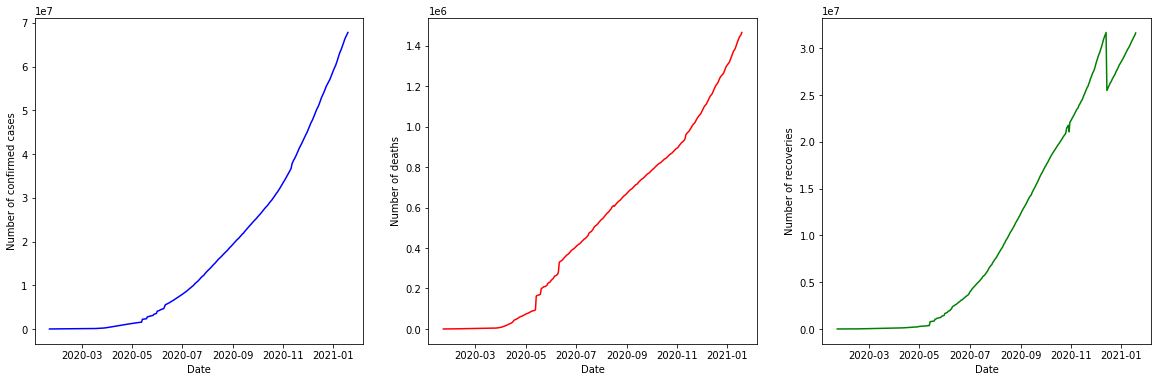

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))

ax1.plot(prophet_df['ds'], prophet_df['y'], color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of confirmed cases')

ax2.plot(prophet_df['ds'], prophet_df['Deaths'], color='red')
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of deaths')

ax3.plot(prophet_df['ds'], prophet_df['Recovered'], color='green')
ax3.set_xlabel('Date')
ax3.set_ylabel('Number of recoveries')

Make predictions for next 90 days.

In [72]:
prediction = model.predict(future_dataframe)

In [73]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,2.812712e+03,-2.451563e+05,1.945101e+05,2.812712e+03,2.812712e+03,-19956.026050,-19956.026050,-19956.026050,-19956.026050,-19956.026050,-19956.026050,0.0,0.0,0.0,-1.714331e+04
1,2020-01-23,4.649774e+03,-1.932092e+05,2.295332e+05,4.649774e+03,4.649774e+03,22593.034031,22593.034031,22593.034031,22593.034031,22593.034031,22593.034031,0.0,0.0,0.0,2.724281e+04
2,2020-01-24,6.486836e+03,-1.768745e+05,2.369475e+05,6.486836e+03,6.486836e+03,34375.234865,34375.234865,34375.234865,34375.234865,34375.234865,34375.234865,0.0,0.0,0.0,4.086207e+04
3,2020-01-25,8.323898e+03,-1.677891e+05,2.621262e+05,8.323898e+03,8.323898e+03,29002.678416,29002.678416,29002.678416,29002.678416,29002.678416,29002.678416,0.0,0.0,0.0,3.732658e+04
4,2020-01-26,1.016096e+04,-2.146185e+05,2.149450e+05,1.016096e+04,1.016096e+04,-7063.626725,-7063.626725,-7063.626725,-7063.626725,-7063.626725,-7063.626725,0.0,0.0,0.0,3.097334e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,2021-04-15,1.050568e+08,1.014132e+08,1.084743e+08,1.014121e+08,1.083972e+08,22593.034031,22593.034031,22593.034031,22593.034031,22593.034031,22593.034031,0.0,0.0,0.0,1.050794e+08
450,2021-04-16,1.054973e+08,1.019201e+08,1.089268e+08,1.017865e+08,1.088930e+08,34375.234865,34375.234865,34375.234865,34375.234865,34375.234865,34375.234865,0.0,0.0,0.0,1.055317e+08
451,2021-04-17,1.059378e+08,1.022096e+08,1.094408e+08,1.021602e+08,1.093941e+08,29002.678416,29002.678416,29002.678416,29002.678416,29002.678416,29002.678416,0.0,0.0,0.0,1.059668e+08
452,2021-04-18,1.063783e+08,1.025547e+08,1.099091e+08,1.025191e+08,1.099091e+08,-7063.626725,-7063.626725,-7063.626725,-7063.626725,-7063.626725,-7063.626725,0.0,0.0,0.0,1.063712e+08


We will only use ds (date column), yhat (forecast), yhat_lower and yhat_upper (for uncertainty interval).

In [74]:
prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
449,2021-04-15,1.050794e+08,1.014132e+08,1.084743e+08
450,2021-04-16,1.055317e+08,1.019201e+08,1.089268e+08
451,2021-04-17,1.059668e+08,1.022096e+08,1.094408e+08
452,2021-04-18,1.063712e+08,1.025547e+08,1.099091e+08
453,2021-04-19,1.067912e+08,1.028548e+08,1.104172e+08


We can plot prediction. The dark-colored part is our dataset and the blue one is our prediction. And light blue part shows the interval between lower and upper limits.

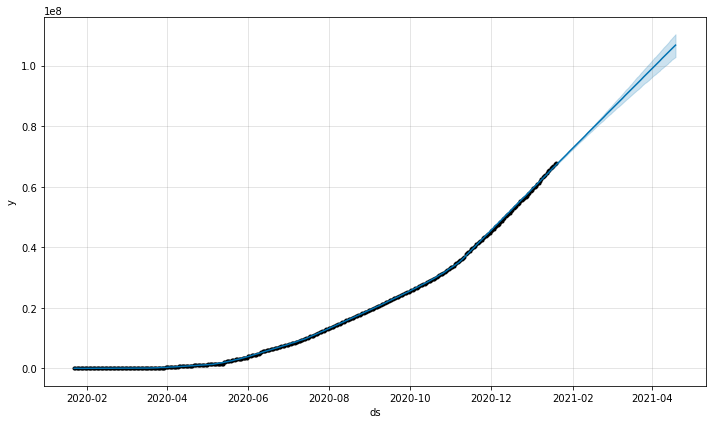

In [75]:
predict_plot = model.plot(prediction)

Use 'plot_components' to plot the components of a prophet forecast.

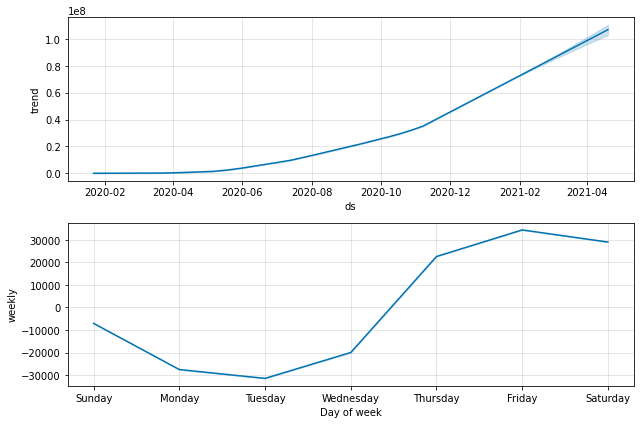

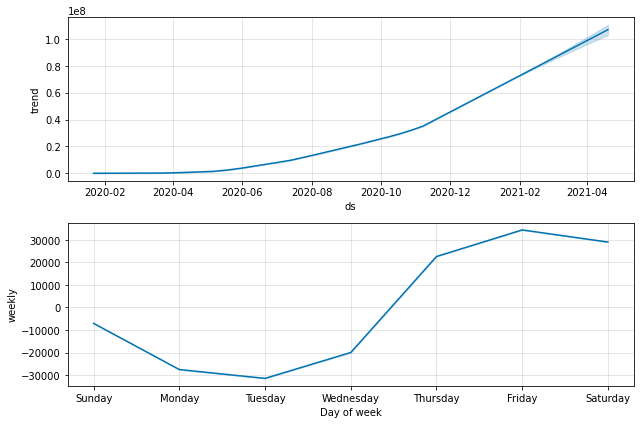

In [76]:
model.plot_components(prediction)

We can also visualize changepoints in time.

[[<matplotlib.lines.Line2D at 0x7fd7d741a1c0>],

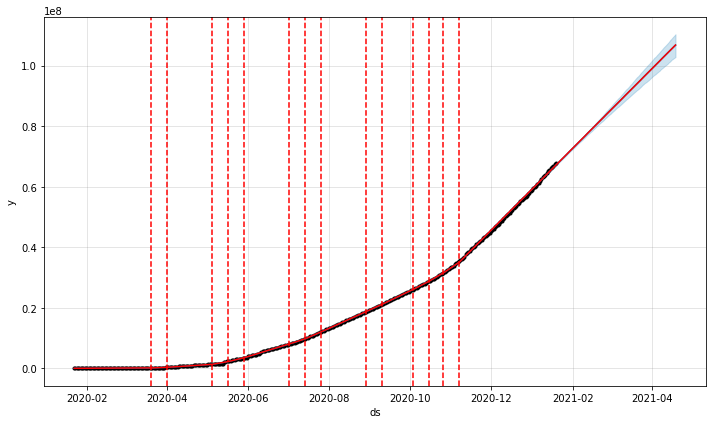

In [77]:
figure = model.plot(prediction)
add_changepoints_to_plot(figure.gca(), model, prediction)

Prophet includes functionality for time series cross-validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point.

Cross-validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. The function takes model, horizon (forecast horizon), initial (size of the initial training period), and period (the spacing between cutoff dates). By default, the initial is set to three times the horizon, and the period is half of the horizon.

In [78]:
cross_validate_df = cross_validation(model, initial='270 days', period='45 days', horizon='90 days')

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-10-21 00:00:00 and 2020-10-21 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

In [79]:
cross_validate_df.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-10-22,3.013707e+07,3.004620e+07,3.023402e+07,30436213.0,2020-10-21
1,2020-10-23,3.035352e+07,3.025828e+07,3.044535e+07,30742657.0,2020-10-21
2,2020-10-24,3.055749e+07,3.046421e+07,3.065902e+07,31009220.0,2020-10-21
3,2020-10-25,3.074811e+07,3.065526e+07,3.084133e+07,31231363.0,2020-10-21
4,2020-10-26,3.095233e+07,3.086143e+07,3.105104e+07,31507849.0,2020-10-21


In [80]:
cross_validate_df.shape

(90, 6)

Get the performance metric to compute statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). 

In [81]:
performance = performance_metrics(cross_validate_df)

The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) and coverage of the yhat_lower and yhat_upper estimates.

In [82]:
performance.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,3.732374e+11,610931.618580,581539.747221,0.018303,0.017631,0.0
1,10 days,4.741085e+11,688555.390305,659264.394539,0.020569,0.020172,0.0
2,11 days,5.913533e+11,768994.998441,738079.080275,0.022824,0.022274,0.0
3,12 days,7.276802e+11,853041.717683,820803.254538,0.025157,0.024418,0.0
4,13 days,8.948476e+11,945963.830073,913591.249767,0.027752,0.027701,0.0


We can visualize cross validation performance metrics with plot_cross_validation_metric.

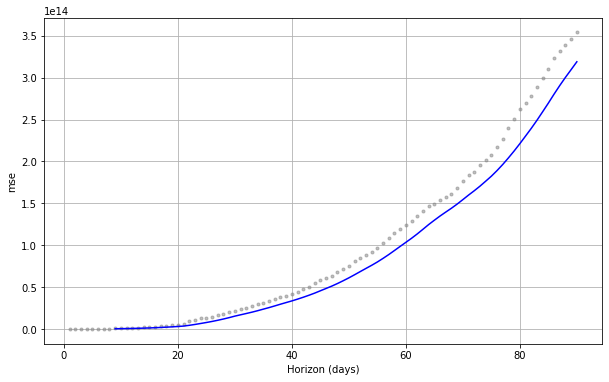

In [83]:
performance_mse = plot_cross_validation_metric(cross_validate_df, metric='mse')

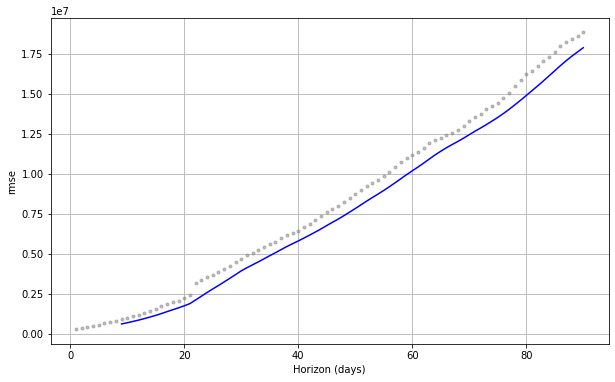

In [84]:
performance_rmse = plot_cross_validation_metric(cross_validate_df, metric='rmse')

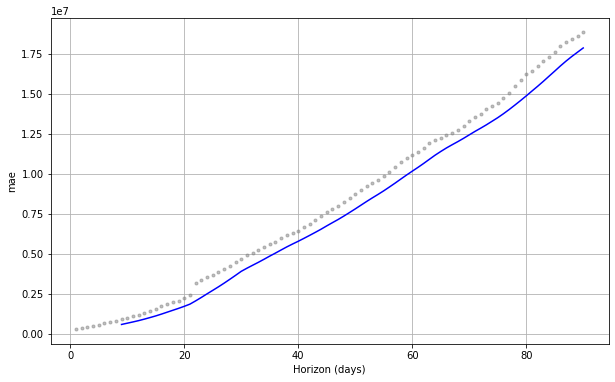

In [85]:
performance_mae = plot_cross_validation_metric(cross_validate_df, metric='mae')